# Identifying pneumonia in X-ray images
Maciej Lorens

In [115]:
import os
from pathlib import Path
import glob
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd

# PyTorch
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchmetrics
from torch.utils.data import Dataset, DataLoader
from torchvision import  models, transforms
import pytorch_lightning as pl

# Sklearn
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import (
    accuracy_score,
    average_precision_score,
    balanced_accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Hyperparameter optimization
import optuna as opt
from optuna.integration import PyTorchLightningPruningCallback

# Image processing
from PIL import Image
from skimage.io import imread
import cv2

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sn
sn.set_theme(style="darkgrid")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [76]:
# Plot the loss curve based on the provided folder or the latest folder from lightning logs
def plot_loss_curve(fpath=None):
    if fpath == None:
        latest_file = os.path.join(max([os.path.join("/home/maciej/Uni/Studia II stopień/II rok/Machine Learning 2/GRU-ML-presentation/lightning_logs", f) 
                                        for f in os.listdir("lightning_logs")], 
                                        key=os.path.getctime), "metrics.csv")
    else:
        latest_file = os.path.join(fpath, "metrics.csv")
    loss_data = pd.read_csv(latest_file)
    loss_data['val_loss'] = loss_data.val_loss.shift(1)
    loss_data = loss_data[["epoch", "train_loss", "val_loss"]].dropna()
    loss_data['epoch'] = loss_data.epoch

    plt.figure(figsize=(10,5))
    plt.plot(loss_data['epoch'], loss_data['train_loss'], label="Training loss")
    plt.plot(loss_data['epoch'], loss_data['val_loss'], label = "Validation loss")
    plt.title("Loss curve", fontsize=18)
    plt.xlabel("Epoch", fontsize=16)
    plt.ylabel("Loss metric", fontsize=16)
    plt.xticks(loss_data['epoch'])
    plt.legend(loc="upper right", fontsize=16)
    plt.tight_layout()
    plt.show()

# Data exploration

In [77]:
# Path to the images of X-rays
data_dir = Path("chest_xray")

# Path to the train directory
train_dir = data_dir / "train"

# Path to test directory
test_dir = data_dir / "test"

In [78]:
def get_image_df(img_dir):
    # Paths to normal and pneumonia xrays
    normal_dir = img_dir / "NORMAL"
    pneumonia_dir = img_dir / "PNEUMONIA"

    # List of all the images
    normal_cases = normal_dir.glob("*.jpeg")
    pneumonia_cases = pneumonia_dir.glob("*.jpeg")

    data = []

    for img in normal_cases:
        data.append((img, 0))

    for img in pneumonia_cases:
        data.append((img, 1))

    data = pd.DataFrame(data, columns=["Image_dir", "Label"])
    data = data.sample(frac=1).reset_index(drop=True)

    return data

In [5]:
# Get a df with an image directory and label
train_data = get_image_df(train_dir)
test_data = get_image_df(test_dir)

In [79]:
train_data.head()

,Image_dir,Label
0,chest_xray/train/PNEUMONIA/person1158_virus_19...,1
1,chest_xray/train/PNEUMONIA/person419_bacteria_...,1
2,chest_xray/train/NORMAL/NORMAL2-IM-0856-0001.jpeg,0
3,chest_xray/train/PNEUMONIA/person23_bacteria_8...,1
4,chest_xray/train/PNEUMONIA/person728_bacteria_...,1


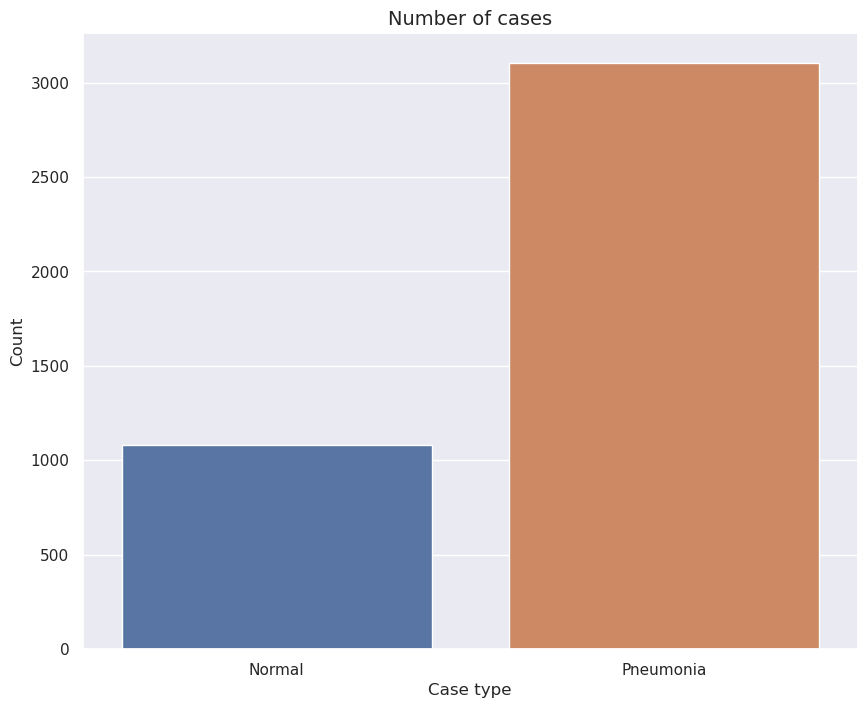

In [81]:
# Get the counts for each class
cases_count = train_data['Label'].value_counts()

# Plot the results 
plt.figure(figsize=(10, 8))
sn.barplot(x=cases_count.index, y= cases_count.values)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(cases_count.index)), ['Normal', 'Pneumonia'])
plt.show()

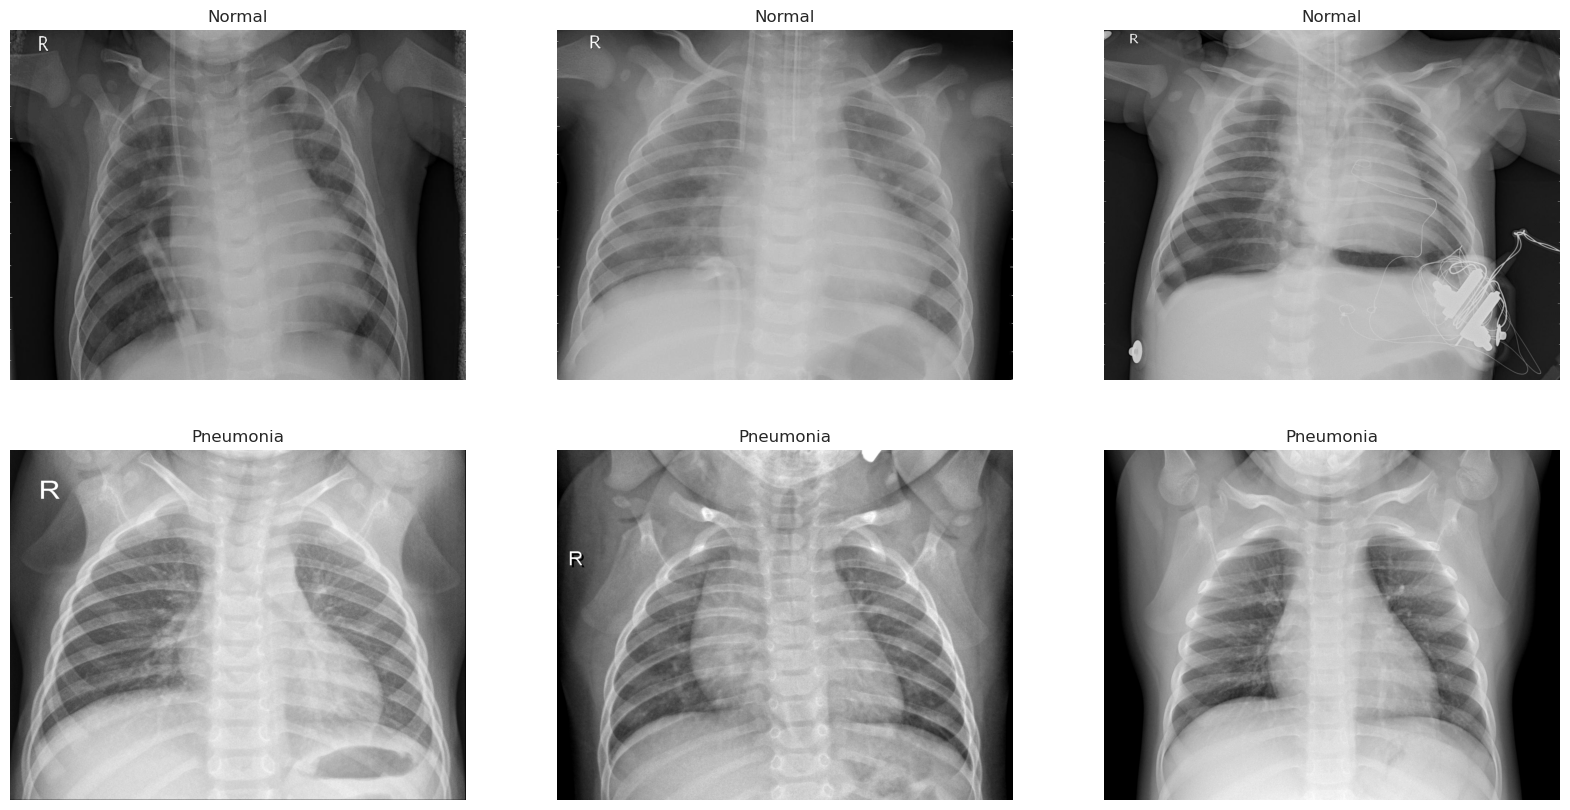

In [82]:
# Get few samples for both the classes
pneumonia_samples = (train_data[train_data['Label']==1]['Image_dir'].iloc[:3]).tolist()
normal_samples = (train_data[train_data['Label']==0]['Image_dir'].iloc[:3]).tolist()

# Concat the data in a single list
samples = pneumonia_samples + normal_samples

# Plot the data 
f, ax = plt.subplots(2, 3, figsize=(20, 10))
for i in range(6):
    img = imread(samples[i])
    ax[i//3, i%3].imshow(img, cmap='gray')
    if i<3:
        ax[i//3, i%3].set_title("Normal")
    else:
        ax[i//3, i%3].set_title("Pneumonia")
    ax[i//3, i%3].axis('off')
    ax[i//3, i%3].set_aspect('auto')
plt.show()

In [83]:
# Splitting train data into train and validation set
train_data, val_data = train_test_split(train_data, test_size=0.2, shuffle=True, stratify=train_data["Label"])
train_data, val_data = train_data.reset_index(drop=True), val_data.reset_index(drop=True)

In [84]:
print(f"Pneumonia cases in the trainining set: {train_data['Label'].value_counts()[1]}, Normal cases in the trainining set: {train_data['Label'].value_counts()[0]}")
print(f"Pneumonia cases in the validation set: {val_data['Label'].value_counts()[1]}, Normal cases in the validation set: {val_data['Label'].value_counts()[0]}")

Pneumonia cases in the trainining set: 2485, Normal cases in the trainining set: 863
Pneumonia cases in the validation set: 621, Normal cases in the validation set: 216


# Modeling

## Dataset and Dataloader

In [8]:
# Custom PyTorch dataset of images
class ImageDataset(Dataset):
    def __init__(self, data, transform, device=device):
        self.data = data
        self.transform = transform
        self.device = device
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        image_dir = self.data.Image_dir[index]
        image = Image.open(image_dir)
        label = self.data.Label[index]
        image = self.transform(image)
        # If image is greyscale then dstack
        if image.shape[0] == 1:
            image = torch.cat((image, image, image), dim=0)

        return (image, torch.tensor(label).to(torch.float32).to(self.device))

In [87]:
# PyTorch Lightning dataloader
class PneumoniaDataLoader(pl.LightningDataModule):
    def __init__(self, train_data, val_data, test_data, random_state, batch_size, num_workers, device):
        super().__init__()
        self.train_data = train_data
        self.val_data = val_data
        self.test_data = test_data
        self.random_sate = random_state
        self.batch_size = batch_size
        self.num_workers = num_workers

    def setup(self, stage):
        # Data transformations for training
        train_transforms = transforms.Compose([
            transforms.Resize((150,150)),
            transforms.RandomRotation(30),
            transforms.RandomHorizontalFlip(p=0.4),
            transforms.ToTensor()
        ])

        # Data transformations for validation and testing
        test_transforms = transforms.Compose([
            transforms.Resize((150,150)),
            transforms.ToTensor()
        ])

        # Create three instances of the custom dataset class
        self.image_train = ImageDataset(self.train_data, transform=train_transforms)
        self.image_val = ImageDataset(self.val_data, transform=test_transforms)
        self.image_test = ImageDataset(self.test_data, transform=test_transforms)

    def train_dataloader(self):
        # Return the dataloader of train data
        return DataLoader(self.image_train
                          , shuffle=True
                          , batch_size=self.batch_size
                          , drop_last=False
                          , num_workers=self.num_workers
                          )

    def val_dataloader(self):
        # Return the dataloader of validation data
        return DataLoader(self.image_val
                          , shuffle=False
                          , batch_size=self.batch_size
                          , drop_last=False
                          , num_workers=self.num_workers
                          )

    def test_dataloader(self):
        # Return the dataloader of test data
        return DataLoader(self.image_test
                          , shuffle=False
                          , batch_size=self.batch_size
                          , drop_last=False
                          , num_workers=self.num_workers
                          )

## PyTorch Models

In [88]:
# Benchmark model class
class BenchmarkCNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(18496, 120) # 16 * 5 * 5
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.softmax = nn.Sigmoid()
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(self.dropout(F.relu(self.conv2(x))))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.softmax(self.fc3(x))
        return x
    

# Transfer learning model with VGG16 for the stacking ensemble
class VGG16Model(nn.Module):
    def __init__(self, dropout):
        super().__init__()
        self.vgg16 = models.vgg16_bn(weights=torchvision.models.VGG16_BN_Weights.DEFAULT)
        num_features = self.vgg16.classifier[-1].in_features
        features = list(self.vgg16.classifier.children())[:-1]
        self.fn = nn.Linear(num_features, 1)
        self.vgg16.classifier = nn.Sequential(*features)
        self.dropout = nn.Dropout(p=dropout)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.vgg16(x)
        x = self.fn(self.dropout(x))

        return self.sigmoid(x)


# Transfer learning model with DenseNet169 for the stacking ensemble
class DenseNetModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.densenet = models.densenet169(weights=torchvision.models.DenseNet169_Weights.DEFAULT)
        self.densenet.classifier = nn.Sequential(nn.Identity()) # or nn.Dropout(p=0.2), nn.Linear(num_features, 1)
    
    def forward(self, x):
        x = self.densenet(x)

        return x
    

# Meta Model for combining outputs of two other models
class MetaModel(nn.Module):
    def __init__(self, modelA, modelB):
        super().__init__()
        self.modelA = modelA
        self.modelB = modelB
        self.fn = nn.Linear(2, 1)
    
    def forward(self, x):
        x1 = self.modelA(x)
        x2 = self.modelB(x)
        x = self.fn(torch.cat((x1, x2), dim=1))

        return x

In [11]:
# Pneumonia classification model created with lightning
class PneumoniaModel(pl.LightningModule):
    def __init__(self, model, lr=0.001):
        super().__init__()
        # Model of choice
        self.model = model
        # Learning rate
        self.lr = lr
        # Metrics
        self.bce = nn.BCELoss()
        self.acc = torchmetrics.Accuracy(task="binary")
        self.auroc = torchmetrics.AUROC(task="binary")


    def training_step(self, batch, batch_idx):
        X, y = batch
        y_pred = self.model(X)
        train_loss = self.bce(y_pred.squeeze(), y)
        self.log("train_loss", train_loss, prog_bar=True, on_step=False, on_epoch=True, sync_dist=True)
        return train_loss
    
    def validation_step(self, batch, batch_idx):
        X, y = batch
        y_pred = self.model(X)
        val_loss = self.bce(y_pred.squeeze(), y)
        self.log("val_loss", val_loss, prog_bar=True, on_step=False, on_epoch=True, sync_dist=True)

    def test_step(self, batch, batch_idx):
        X, y = batch
        y_pred = self.model(X)
        test_bce = self.bce(y_pred.squeeze(), y)
        test_acc = self.acc(y_pred.squeeze(), y.to(torch.int64))
        test_roc = self.auroc(y_pred.squeeze(), y.to(torch.int64))
        self.log_dict({"BCE": test_bce, "Accuracy": test_acc, "ROC": test_roc}, prog_bar=True, on_step=False, on_epoch=True, sync_dist=True)
        # self.log("test_loss", test_loss, prog_bar=True, on_step=False, on_epoch=True, sync_dist=True)
    
    def predict_step(self, batch, batch_id):
        X, y = batch
        y_pred = self.model(X)

        return y_pred

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

## Model training and validation

In [89]:
# Initialize dataloader
pneumonia_loader = PneumoniaDataLoader(train_data=train_data
                                       , val_data=val_data
                                       , test_data=test_data
                                       , random_state=42
                                       , batch_size=128
                                       , num_workers=7
                                       , device=device
                                       )

### Benchmark model

In [86]:
pl.seed_everything(42, workers=True)
benchmark_model = PneumoniaModel(BenchmarkCNNModel().to(device), lr=0.01)
benchmark_trainer = pl.Trainer(max_epochs=10, check_val_every_n_epoch=2, log_every_n_steps=2)

Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [75]:
benchmark_trainer.fit(benchmark_model, datamodule=pneumonia_loader)


  | Name  | Type              | Params
--------------------------------------------
0 | model | BenchmarkCNNModel | 2.2 M 
1 | bce   | BCELoss           | 0     
2 | acc   | BinaryAccuracy    | 0     
3 | auroc | BinaryAUROC       | 0     
--------------------------------------------
2.2 M     Trainable params
0         Non-trainable params
2.2 M     Total params
8.931     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [76]:
benchmark_trainer.test(benchmark_model, dataloaders=pneumonia_loader.test_dataloader())

Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Accuracy            0.6730769276618958
           BCE              0.6289148330688477
           ROC              0.6919010877609253
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'BCE': 0.6289148330688477,
  'Accuracy': 0.6730769276618958,
  'ROC': 0.6919010877609253}]

### VGG16 Model

In [ ]:
pl.seed_everything(42, workers=True)

def objective(trial):
    batch_size = trial.suggest_int("batch_size", 32, 1e-3)
    dropout = trial.suggest_float("dropout", 0.2, 0.5)
    lr = trial.suggest_float("lr", 1e-3, 1e-1)

    vgg16_model = VGG16Model(dropout=dropout).to(device)
    vgg16_model.vgg16.requires_grad_(False)
    model = PneumoniaModel(vgg16_model, lr=lr)

    optuna_loader = PneumoniaDataLoader(train_data=train_data
                                        , val_data=val_data
                                        , test_data=test_data
                                        , random_state=42
                                        , batch_size=batch_size
                                        , num_workers=7
                                        , device=device
                                        )
    
    optuna_trainer = pl.Trainer(max_epochs=5
                                , enable_checkpointing=False
                                , callbacks=[PyTorchLightningPruningCallback(trial, monitor="val_loss")])
    
    hyperparameters = dict(batch_size=batch_size, dropout=dropout, lr=lr)
    optuna_trainer.logger.log_hyperparams(hyperparameters)
    optuna_trainer.fit(model, datamodule=optuna_loader)

    return optuna_trainer.callback_metrics["val_loss"].item()

study = opt.create_study(direction="minimize", study_name="vgg16_model", pruner=opt.pruners.HyperbandPruner())

study.optimize(objective, n_trials=100, n_jobs=-1)

print("Best hyperparameters: ", study.best_params)
print("Score on validation: ", study.best_value)

In [112]:
pl.seed_everything(42, workers=True)
vgg16_model = VGG16Model().to(device)
vgg16_model.vgg16.requires_grad_(False)

vgg16_model_lightning = PneumoniaModel(vgg16_model, lr=0.01)
vgg16_trainer = pl.Trainer(max_epochs=5, check_val_every_n_epoch=2, log_every_n_steps=2)

Seed set to 42


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [113]:
vgg16_trainer.fit(vgg16_model_lightning, datamodule=pneumonia_loader)


  | Name  | Type           | Params
-----------------------------------------
0 | model | VGG16Model     | 134 M 
1 | bce   | BCELoss        | 0     
2 | acc   | BinaryAccuracy | 0     
3 | auroc | BinaryAUROC    | 0     
-----------------------------------------
4.1 K     Trainable params
134 M     Non-trainable params
134 M     Total params
537.092   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


In [114]:
vgg16_trainer.test(vgg16_model_lightning, dataloaders=pneumonia_loader.test_dataloader())

Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Accuracy            0.8253205418586731
           BCE              0.5503507256507874
           ROC              0.8868200778961182
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'BCE': 0.5503507256507874,
  'Accuracy': 0.8253205418586731,
  'ROC': 0.8868200778961182}]

### Densenet169 and SVM Classifier

#### Special dataloaders for Densenet169 with SVM Classifier

In [90]:
train_transforms = transforms.Compose([
    transforms.Resize((150,150)),
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(p=0.4),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize((150,150)),
    transforms.ToTensor()
])

# Create three instances of the custom dataset class
image_train = ImageDataset(train_data, transform=train_transforms)
image_val = ImageDataset(val_data, transform=train_transforms)
image_test = ImageDataset(test_data, transform=test_transforms)

train_loader = DataLoader(image_train
                          , shuffle=False 
                          # Batch size doesn't matter here, since we're not training the CNN
                          , batch_size=128
                          , drop_last=False
                          , num_workers=7
                          )

val_loader = DataLoader(image_val
                        , shuffle=False
                        # Batch size doesn't matter here, since we're not training the CNN
                        , batch_size=128
                        , drop_last=False
                        , num_workers=7
                        )

test_loader = DataLoader(image_test
                         , shuffle=False
                         # Batch size doesn't matter here, since we're not training the CNN
                         , batch_size=128
                         , drop_last=False
                         , num_workers=7
                         )

#### Initialize DenseNet169 with pretrained weights

In [91]:
pl.seed_everything(42, workers=True)
densenet_model = DenseNetModel().to(device)
densenet_model.densenet.requires_grad_(False)

Seed set to 42


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [92]:
def get_densenet_predictions(dataloader, model, device):
    model.eval()
    cnn_preds_all = []

    for X, _ in tqdm(dataloader, total=len(dataloader)):
        cnn_preds = model(X)
        cnn_preds_all += [cnn_preds.detach().cpu().numpy()]
    
    cnn_preds_all = np.concatenate(cnn_preds_all, axis=0)
    
    return cnn_preds_all

In [93]:
train_features = get_densenet_predictions(train_loader, densenet_model, device)
val_features = get_densenet_predictions(val_loader, densenet_model, device)
test_features = get_densenet_predictions(test_loader, densenet_model, device)

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

#### SVM Classifier

In [103]:
# Tuning LinearSVC hyperparameters with Optuna
def objective(trial):
    
    params = dict(
        tol = trial.suggest_float("tol", 1e-6, 1e-3),
        C = trial.suggest_float("C", 1e-2, 1e-1),
        penalty = trial.suggest_categorical("penalty", ["l1", "l2"]),
        class_weight = trial.suggest_categorical("class_weight", ["balanced", None])
    )
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    svc_model = LinearSVC(**params, dual="auto", loss="squared_hinge", random_state=42)

    svc_pipe = Pipeline([("scaler", StandardScaler())
                     , ("model", svc_model)])

    metric = 'balanced_accuracy'
    
    score = np.mean(cross_val_score(svc_pipe, train_features, np.array(train_data["Label"]), cv=cv, scoring=metric, n_jobs=-1))

    return score

study = opt.create_study(direction="maximize", study_name="linear_svc", pruner=opt.pruners.HyperbandPruner())

study.optimize(objective, n_trials=100, n_jobs=-1)

print("Best hyperparameters: ", study.best_params)
print("Score on validation: ", study.best_value)

[I 2024-01-10 22:01:54,222] A new study created in memory with name: linear_svc
[I 2024-01-10 22:02:03,157] Trial 5 finished with value: 0.9440970598425882 and parameters: {'tol': 0.0007145298669905103, 'C': 0.029403739409893458, 'penalty': 'l2', 'class_weight': 'balanced'}. Best is trial 5 with value: 0.9440970598425882.
[I 2024-01-10 22:02:18,338] Trial 1 finished with value: 0.9426820162810443 and parameters: {'tol': 0.0009277595492351694, 'C': 0.09769577521520961, 'penalty': 'l2', 'class_weight': None}. Best is trial 5 with value: 0.9440970598425882.
[I 2024-01-10 22:02:23,871] Trial 2 finished with value: 0.9445250613778111 and parameters: {'tol': 0.0001987347916400363, 'C': 0.062029292269325534, 'penalty': 'l2', 'class_weight': 'balanced'}. Best is trial 2 with value: 0.9445250613778111.
[I 2024-01-10 22:02:34,920] Trial 7 finished with value: 0.9596042446370656 and parameters: {'tol': 8.664881249781997e-05, 'C': 0.016894115733652133, 'penalty': 'l1', 'class_weight': 'balanced'}.

Best hyperparameters:  {'tol': 0.00017130359107544874, 'C': 0.014436705542736596, 'penalty': 'l1', 'class_weight': 'balanced'}
Score on validation:  0.9609392948631431


In [104]:
svc_model = LinearSVC(**study.best_params, dual="auto", loss="squared_hinge", random_state=42)

svc_pipe = Pipeline([("scaler", StandardScaler())
                    , ("model", svc_model)])

In [105]:
svc_pipe.fit(train_features, np.array(train_data["Label"]))

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 LinearSVC(C=0.014436705542736596, class_weight='balanced',
                           dual='auto', penalty='l1', random_state=42,
                           tol=0.00017130359107544874))])

In [106]:
svc_train_preds = svc_pipe.predict(train_features)
svc_val_preds = svc_pipe.predict(val_features)

In [107]:
print(f"Training set balanced accuracy: {balanced_accuracy_score(svc_train_preds, np.array(train_data['Label']))}")
print(f"Training set f1-score: {f1_score(svc_train_preds, np.array(train_data['Label']))}")
print("-" * 50)
print(f"Validation set balanced accuracy: {balanced_accuracy_score(svc_val_preds, np.array(val_data['Label']))}")
print(f"Validation set f1-score: {f1_score(svc_val_preds, np.array(val_data['Label']))}")

Training set balanced accuracy: 0.9451834991091596
Training set f1-score: 0.977258758451137
--------------------------------------------------
Validation set balanced accuracy: 0.9446459105158165
Validation set f1-score: 0.9755301794453507


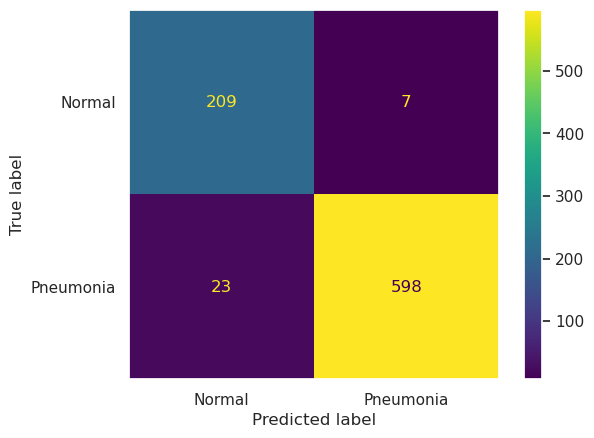

In [114]:
# Confusion matrix of SVC predictions on the validation set
conf_matrix = confusion_matrix(np.array(val_data['Label']), svc_val_preds, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Normal", "Pneumonia"])
disp.plot()
plt.grid(False)
plt.show()